<a href="https://colab.research.google.com/github/peterjsadowski/tutorial_climate_ai/blob/main/01_warmup_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warmup: Digit Classification

Before we start looking at climate data, we will build a simple image classification model using the MNIST dataset. This dataset consists of 70,000 images of handwritten digits (0-9) that are 28x28 pixels. The goal is to train a model that can correctly classify the digits.




## Import libraries

To start, import all the relevant libraries.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## Select a device

Before we start, we need to select a device to train the model on. If you are using Google Colab, you can use a GPU by selecting Runtime -> Change runtime type -> Hardware accelerator -> GPU. If you are using your own computer, you can use a GPU if you have one available. Otherwise, you can use the CPU.



In [2]:
torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device(type='cpu')

## Download the MNIST dataset

As the MNIST dataset is a common dataset, it is already available in the torchvision package. We can download the data and preprocess it using the following code.



In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.14MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.70MB/s]


Here we also split the data into training and test sets. The training set is used to train the model, while the test set is used to evaluate the model. Machine learning models perform well on the data they are trained on, but the real test is how well they perform on unseen data. This is known as cross-validation.



In [4]:
print("Train data:\n", train_data)
print("\nTest data:\n", test_data)

Train data:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


The MNIST dataset is already split into training and test sets, but in general we need to do this ourselves. It is important to split the data randomly, but also to make sure that the training and test sets are representative of the entire dataset. For example, if the dataset is 90% class A and 10% class B, then the training and test sets should also be 90% class A and 10% class B. We can plot some examples from the dataset to get a sense of what the data looks like.

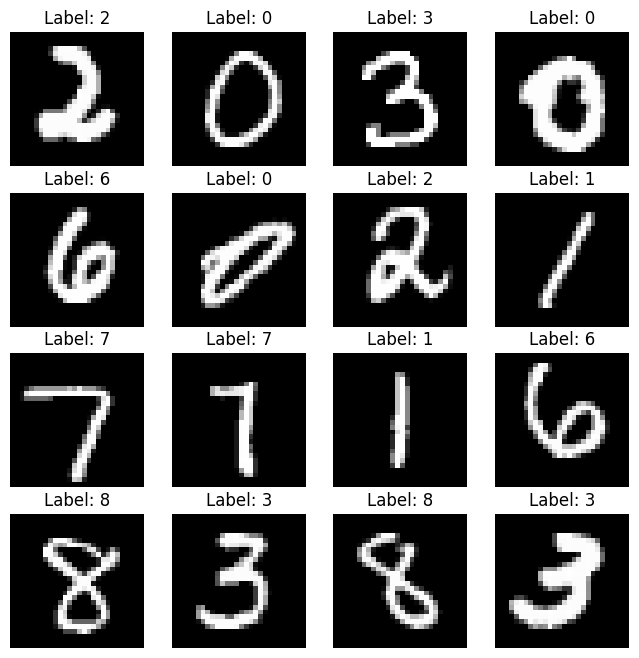

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Prepare the data for training

We need to prepare the data for training. This involves creating a data loader that will feed the data into the model in batches. This is important because it is not feasible to load the entire dataset into memory at once. Instead, we load a small batch of data, perform a forward pass through the model, compute the loss, and then update the model parameters. This is known as stochastic gradient descent.



In [6]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Define the model

For this particular problem, we will use a convolutional neural network (CNN). CNNs are a type of neural network that are particularly adept at processing image data. They are composed of a series of convolutional layers, which are layers that apply a filter to the input image. The filters can be thought of as small windows that slide across the image and extract features.

In Pytorch, we can define a CNN model by creating a class that inherits from the `nn.Module` class. We then define the layers of the model in the `__init__` method, and define the forward pass in the `forward` method. The `forward` method takes in an input tensor and returns an output tensor.



In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The model can be used by assigning it to a variable and calling it like a function.


In [8]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Train the model

Now we are ready to train the model. We first define the loss function and the optimizer. The loss function is a measure of how well the model is performing. The optimizer is the algorithm that will update the model parameters to minimize the loss function. Here we use the cross entropy loss function and the Adam optimizer.



In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We then define the training loop. This is where we iterate through the training examples, make predictions, and update the model parameters. We keep track of the average loss over the training set, and report it every time we iterate through the training dataset — each iteration through the training set is called an **epoch**.



In [10]:
# train
epochs = 10
train_loss = []

for epoch in range(epochs):
    epoch_loss = []

    # set the model in training phase
    model.train()

    for batch_idx, (data, target) in enumerate(train_dataloader):
        # zero the parameter gradients
        # this is because the gradients are accumulated
        # so we need to zero them out at each iteration
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(data)
        loss = loss_fn(output, target)

        # we save the epoch loss to plot it later
        # it is multiplied by the batch size to account for the fact that
        # the loss is averaged over the batch
        epoch_loss.append(loss.item() * data.size(0))

        loss.backward()
        optimizer.step()

        # print statistics
        if batch_idx % 400 == 0:
            print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")
    train_loss.append(sum(epoch_loss) / len(train_data))

Epoch: 0, Batch: 0, Loss: 2.3044819831848145
Epoch: 0, Batch: 400, Loss: 0.13680586218833923
Epoch: 0, Batch: 800, Loss: 0.03400668874382973
Epoch: 1, Batch: 0, Loss: 0.08120855689048767
Epoch: 1, Batch: 400, Loss: 0.06176663562655449
Epoch: 1, Batch: 800, Loss: 0.17648157477378845
Epoch: 2, Batch: 0, Loss: 0.12767624855041504
Epoch: 2, Batch: 400, Loss: 0.09352590143680573
Epoch: 2, Batch: 800, Loss: 0.06914792954921722
Epoch: 3, Batch: 0, Loss: 0.046865325421094894
Epoch: 3, Batch: 400, Loss: 0.004199458751827478
Epoch: 3, Batch: 800, Loss: 0.0638388991355896
Epoch: 4, Batch: 0, Loss: 0.007981343194842339
Epoch: 4, Batch: 400, Loss: 0.003867829218506813
Epoch: 4, Batch: 800, Loss: 0.017100708559155464
Epoch: 5, Batch: 0, Loss: 0.005670569371432066
Epoch: 5, Batch: 400, Loss: 0.0518307201564312
Epoch: 5, Batch: 800, Loss: 0.030179789289832115
Epoch: 6, Batch: 0, Loss: 0.012595139443874359
Epoch: 6, Batch: 400, Loss: 0.04176996275782585
Epoch: 6, Batch: 800, Loss: 0.04673063009977341
E

Training a neural network is notoriously difficult. The problem is that we are performing stochastic gradient descent optimization on a very non-convex function. You should look to see that the loss function decreases during the first few epochs, indicating that the model is improving. If it doesn’t, try decreasing the learning rate. If that doesn’t help, then you have a bug or the model is not appropriate for your problem.

It is hard to know when to stop training, because even when the model seems to have converged, it might suddenly have “a revelation” that allows it to explain the training data perfectly. To build your intuition, we highly recommend playing with the toy neural networks in [Tensorflow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.64984&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

In practice, we train until we run out of patience or when we start overfitting to a held out test set (known as early stopping).

It is useful to plot the training loss to see how the model is improving.

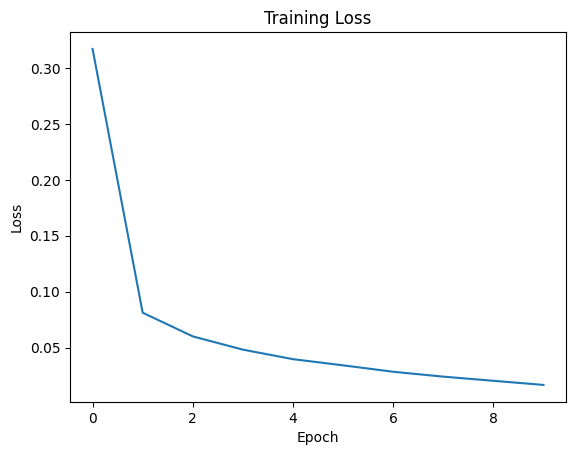

In [11]:
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Evaluate the model

To evaluate the model, it is very important to use set of data that was not used for training. This is because the model tends to memorize the training set examples and achieve 100% accuracy on the training set if we train long enough.

We set the model to evaluation mode, then iterate through the test set and make predictions. We then compare the predictions to the ground truth labels and compute the accuracy.


In [36]:
# set model to evaluation mode
model.eval()

# variables to keep track of accuracy
all_predictions = []
all_targets = []
all_data = []
test_loss = []


# we don't need to compute gradients for the test set
with torch.no_grad():
    for data, target in test_dataloader:
        output = model(data)

        # The loss is the cross-entropy loss, based on probabilistic predictions.
        loss = loss_fn(output, target)
        test_loss.append(loss.item() * data.size(0))

        # Make hard prediction to compute accuracy metric.
        _, predicted = torch.max(output.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_data.extend(data.cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
accuracy = 100 * sum(all_predictions == all_targets) / len(all_targets)

print(f"Test Accuracy: {accuracy}%")
print(f"Test Loss: {np.mean(test_loss)}")

Test Accuracy: 98.83%
Test Loss: 2.4099559332288587


It's also good to visualize some of the predictions to get a sense of how well the model is performing after training. Visualizing the errors is almost always a good idea.

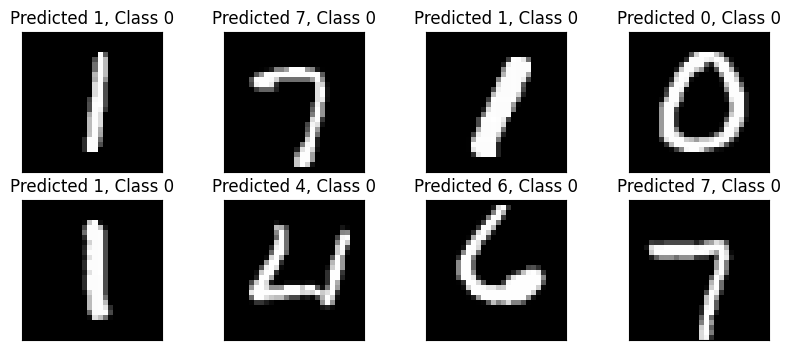

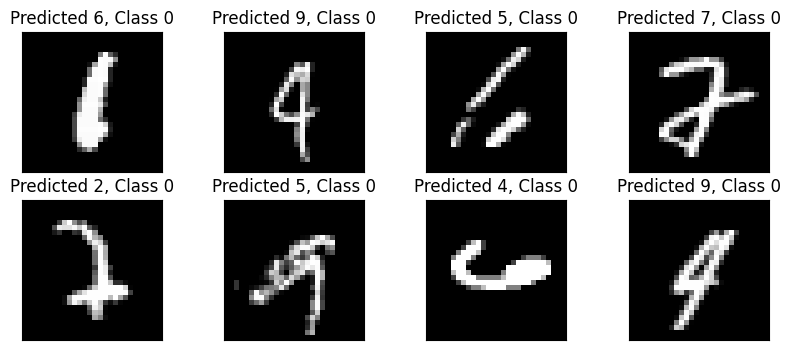

In [37]:
# Get indices of correct and incorrect examples
correct_indices   = np.nonzero(all_predictions == all_targets)[0]
incorrect_indices = np.nonzero(all_predictions != all_targets)[0]

# Plot some correctly labeled examples.
plt.figure(1, figsize=(10,4))
for i, correct in enumerate(correct_indices[:8]):
    plt.subplot(2,4,i+1)
    plt.imshow(all_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(all_predictions[correct], all_targets[correct].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])

# Plot some incorrectly labeled examples.
plt.figure(2, figsize=(10,4))
for i, incorrect in enumerate(incorrect_indices[:8]):
    plt.subplot(2,4,i+1)
    plt.imshow(all_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(all_predictions[incorrect], all_targets[incorrect].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])
